In [1]:
import pandas as pd
import numpy as np
import pickle
import argparse
import os
from datetime import datetime


import torch


In [2]:
# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:4')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : NVIDIA GeForce RTX 2080 Ti


# Arguments

In [3]:
# @title Arguments
parser = argparse.ArgumentParser(description='Actor Critic')

parser.add_argument('--data', default="/mnt/kerem/CEU", type=str, help='Dataset Path')
parser.add_argument('--epochs', default=64, type=int, metavar='N', help='Number of epochs for training agent.')
parser.add_argument('--episodes', default=10000, type=int, metavar='N', help='Number of episodes for training agent.')
parser.add_argument('--lr', '--learning-rate', default=0.005, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', default=0.0001, type=float, help='Weight decay for training optimizer')
parser.add_argument('--seed', default=3, type=int, help='Seed for reproducibility')
parser.add_argument('--model-name', default="PPO", type=str, help='Model name for saving model.')
parser.add_argument('--gamma', default=0.99, type=float, metavar='N', help='The discount factor as mentioned in the previous section')

# Model
parser.add_argument("--latent1", default=256, required=False, help="Latent Space Size for first layer of network.")
parser.add_argument("--latent2", default=256, required=False, help="Latent Space Size for second layer of network.")

# Env Properties
parser.add_argument('--control_size', default=20, type=int, help='Beacon and Attacker Control group size')
parser.add_argument('--gene_size', default=100, type=int, help='States gene size')
parser.add_argument('--beacon_size', default=60, type=int, help='Beacon population size')
parser.add_argument('--victim_prob', default=0.8, type=float, help='Victim inside beacon or not!')
parser.add_argument('--pop_reset_freq', default=10, type=int, help='Reset Population Frequency (Epochs)')
parser.add_argument('--max_queries', default=10, type=int, help='Maximum queries per episode')


parser.add_argument("--state_dim", default=(4,), required=False, help="State Dimension")
parser.add_argument("--n-actions", default=1, required=False, help="Actions Count for each state")


# utils
parser.add_argument('--resume', default="", type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--save-dir', default='./results', type=str, metavar='PATH', help='path to cache (default: none)')

# args = parser.parse_args()  # running in command line
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
if args.save_dir == '':
    args.save_dir = "./"

args.results_dir = args.save_dir

if not os.path.exists(args.results_dir):
      os.makedirs(args.results_dir)

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(args)

Namespace(data='/mnt/kerem/CEU', epochs=64, episodes=10000, lr=0.005, wd=0.0001, seed=3, model_name='PPO', gamma=0.99, latent1=256, latent2=256, control_size=20, gene_size=100, beacon_size=60, victim_prob=0.8, pop_reset_freq=10, max_queries=10, state_dim=(4,), n_actions=1, resume='', save_dir='./results', results_dir='./results', device=device(type='cuda'))


# Read Data

In [4]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(os.path.join(args.data, "Beacon_164.txt"), index_col=0, delim_whitespace=True)
# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(os.path.join(args.data, "reference.pickle"),"rb"))
# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

In [5]:
# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(os.path.join(args.data, "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)
# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')
# Extracting column to an array for future use
maf_values = maf["maf"].values

In [6]:
beacon.shape, reference.shape, binary.shape, maf_values.shape

((4029840, 164), (4029840, 1), (4029840, 164), (4029840,))

# PPO

In [7]:
has_continuous_action_space = True                
max_training_timesteps = int(1e10)   # break training loop if timeteps > max_training_timesteps

action_std = 0.4                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)

################ PPO hyperparameters ################
update_timestep = args.max_queries * 4      # update policy every n timesteps
K_epochs = 64           # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Victim is inside the Beacon!
Started training at (GMT) :  2024-04-13 20:41:42
current logging run number for  :  31
logging at : ./results/PPO__log_31.csv
save checkpoint path : ./results/weights/PPO_31.pth
Episode:  0
preward:  tensor(1.)
ureward:  [-0.6357964]
preward:  tensor(0.)
ureward:  [-0.9979915]
preward:  tensor(0.)
ureward:  [-1.7851993]
preward:  tensor(0.)
ureward:  [-1.4147114]
preward:  tensor(0.)
ureward:  [-1.3038118]
preward:  tensor(0.)
ureward:  [-1.4713123]
preward:  tensor(0.)
ureward:  [-1.6566231]
preward:  tensor(0.)
ureward:  [-1.832867]
preward:  tensor(0.)
ureward:  [-2.7278886]
preward:  tensor(0.)
ureward:  [-3.3973367]
Episode:  1
preward:  tensor(0.0220)
ureward:  [-0.38100153]
preward:  tensor(0.)
ureward:  [0.03329933]
preward:  tensor(0.)
ureward:  [-0.47397327]
preward:  tensor(0.)
ureward:  [-0.604843]
preward:  tensor(0.)
ureward:  [-0.9264046]
preward:  tensor(

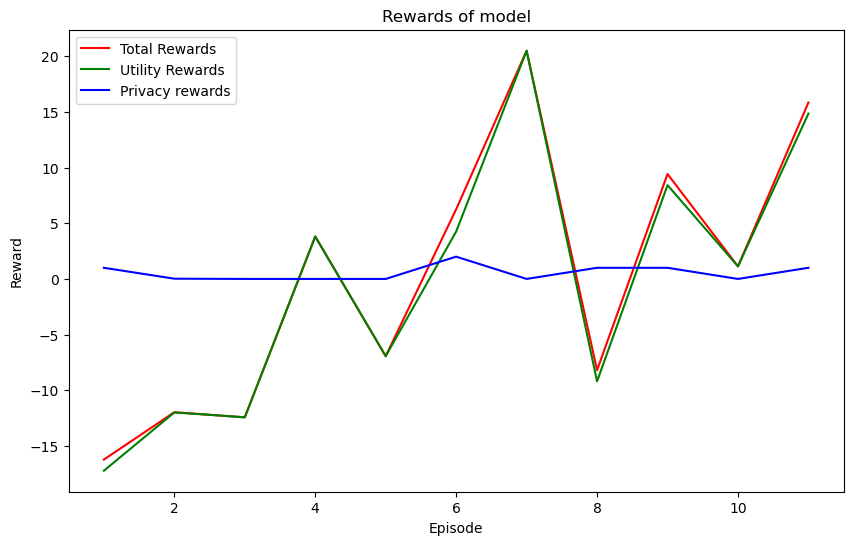

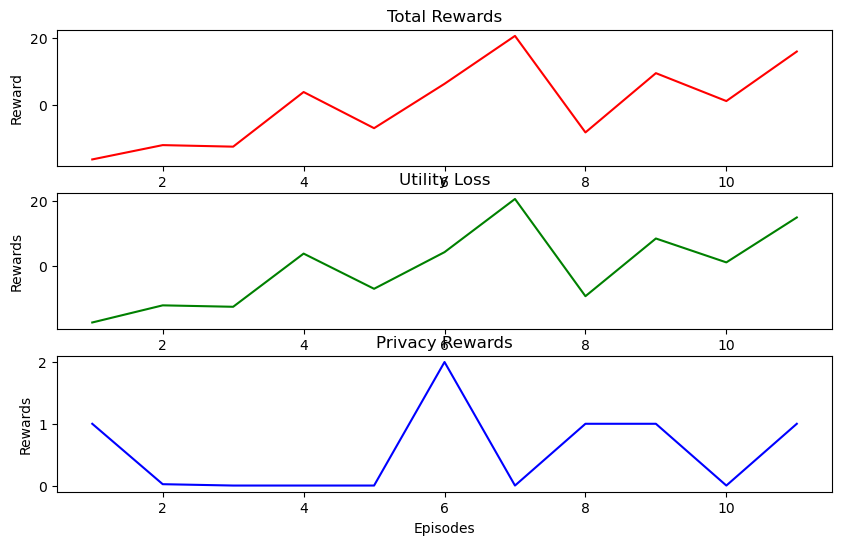

Episode:  11
preward:  tensor(0.)
ureward:  [0.30390435]
preward:  tensor(0.)
ureward:  [0.05200917]
preward:  tensor(0.)
ureward:  [-0.07561159]
preward:  tensor(0.)
ureward:  [-0.5406558]
preward:  tensor(0.)
ureward:  [-0.7970436]
preward:  tensor(0.)
ureward:  [-1.391285]
preward:  tensor(0.)
ureward:  [-1.7337437]
preward:  tensor(0.)
ureward:  [-2.2223191]
preward:  tensor(0.)
ureward:  [-2.575594]
preward:  tensor(0.)
ureward:  [-3.1473846]
Episode:  12
preward:  tensor(0.)
ureward:  [0.25678617]
preward:  tensor(0.)
ureward:  [-0.1429019]
preward:  tensor(0.)
ureward:  [-0.07841896]
preward:  tensor(0.)
ureward:  [-0.3677215]
preward:  tensor(0.)
ureward:  [-0.3502384]
preward:  tensor(0.)
ureward:  [-0.6926849]
preward:  tensor(0.)
ureward:  [-0.8075051]
preward:  tensor(0.)
ureward:  [-1.6858132]
preward:  tensor(0.)
ureward:  [-1.9365356]
preward:  tensor(0.)
ureward:  [-2.2952037]
Episode:  13
preward:  tensor(1.)
ureward:  [0.10598943]
preward:  tensor(0.)
ureward:  [-0.44

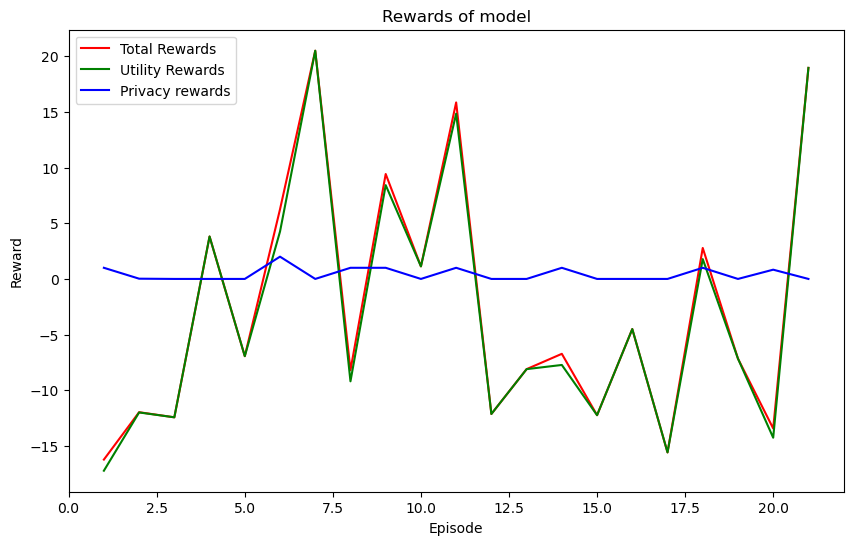

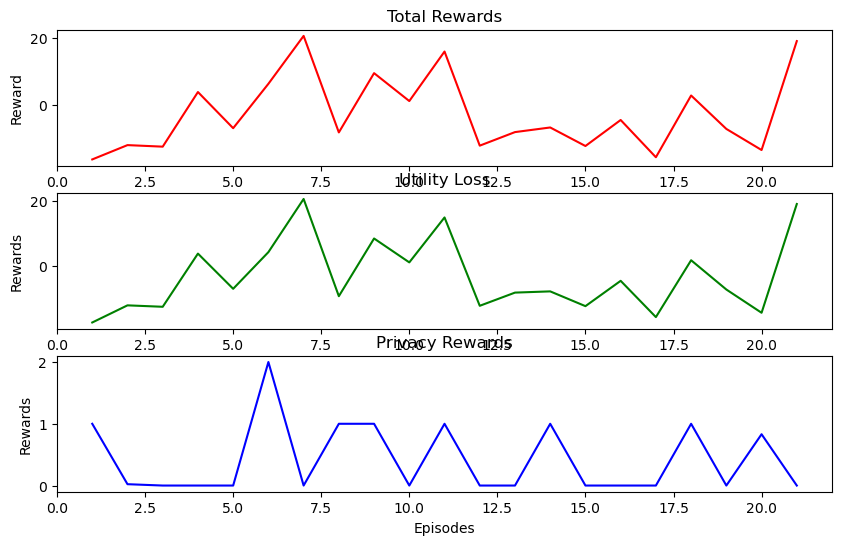

Episode:  21
preward:  tensor(0.)
ureward:  [0.26061246]
preward:  tensor(0.)
ureward:  [1.0623642]
preward:  tensor(0.)
ureward:  [1.7660713]
preward:  tensor(0.)
ureward:  [2.065896]
preward:  tensor(0.)
ureward:  [2.4412017]
preward:  tensor(0.)
ureward:  [2.3992157]
preward:  tensor(0.)
ureward:  [2.930558]
preward:  tensor(0.)
ureward:  [2.8316772]
preward:  tensor(0.)
ureward:  [2.9849458]
preward:  tensor(0.)
ureward:  [2.9595912]
Episode:  22
preward:  tensor(1.)
ureward:  [0.50365114]
preward:  tensor(0.)
ureward:  [0.40187865]
preward:  tensor(0.)
ureward:  [0.9001862]
preward:  tensor(0.)
ureward:  [1.0635037]
preward:  tensor(0.)
ureward:  [1.4808753]
preward:  tensor(0.)
ureward:  [1.5412823]
preward:  tensor(0.)
ureward:  [1.5198764]
preward:  tensor(0.)
ureward:  [2.3409023]
preward:  tensor(0.)
ureward:  [2.5652483]
preward:  tensor(0.)
ureward:  [2.7951493]
Episode:  23
preward:  tensor(0.)
ureward:  [0.5414965]
preward:  tensor(0.)
ureward:  [0.59612584]
preward:  ten

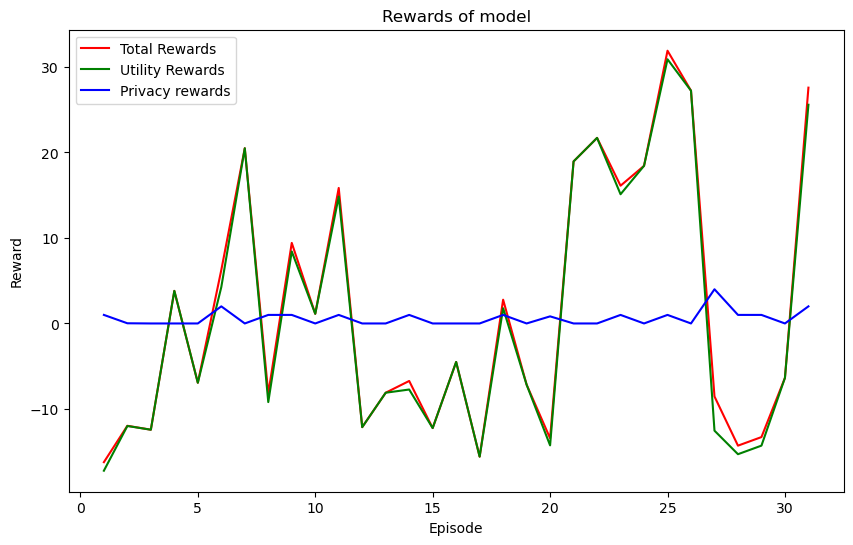

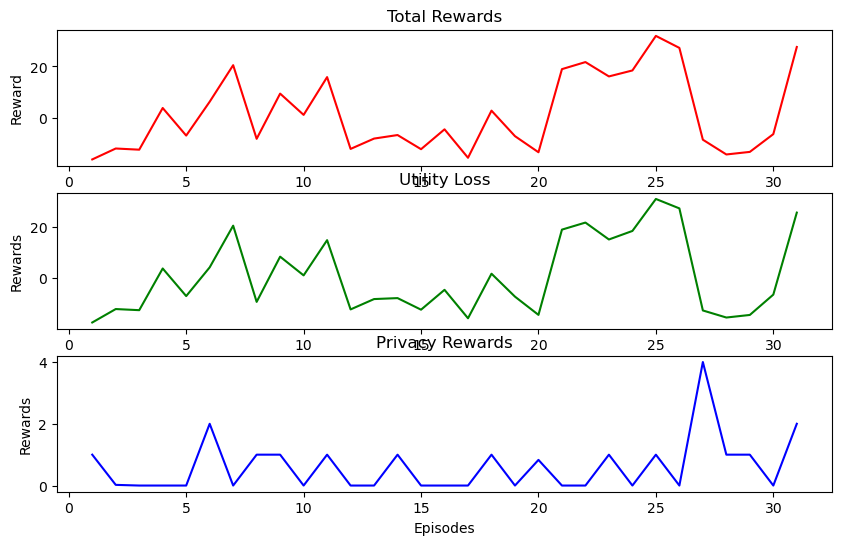

Episode:  31
preward:  tensor(0.)
ureward:  [0.24532437]
preward:  tensor(0.)
ureward:  [0.31513554]
preward:  tensor(0.)
ureward:  [0.48640862]
preward:  tensor(0.)
ureward:  [-0.0669879]
preward:  tensor(0.)
ureward:  [0.8165103]
preward:  tensor(0.)
ureward:  [1.6292772]
preward:  tensor(0.)
ureward:  [2.533149]
preward:  tensor(0.)
ureward:  [2.680447]
preward:  tensor(0.)
ureward:  [2.6130567]
preward:  tensor(0.)
ureward:  [2.5985334]
Episode:  32
preward:  tensor(1.)
ureward:  [0.3331577]
preward:  tensor(0.)
ureward:  [1.3331577]
preward:  tensor(0.)
ureward:  [2.0488276]
preward:  tensor(0.)
ureward:  [2.7128897]
preward:  tensor(0.)
ureward:  [3.544583]
preward:  tensor(0.)
ureward:  [3.6702871]
preward:  tensor(0.)
ureward:  [4.670287]
preward:  tensor(0.)
ureward:  [5.564336]
preward:  tensor(0.)
ureward:  [6.564336]
preward:  tensor(0.)
ureward:  [6.938338]
Episode:  33
preward:  tensor(0.)
ureward:  [0.639997]
preward:  tensor(0.)
ureward:  [0.7113569]
preward:  tensor(0.

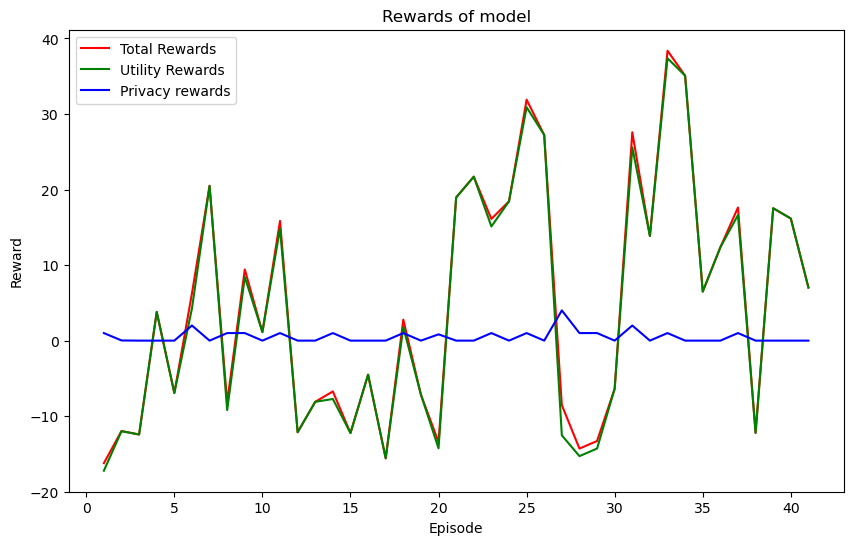

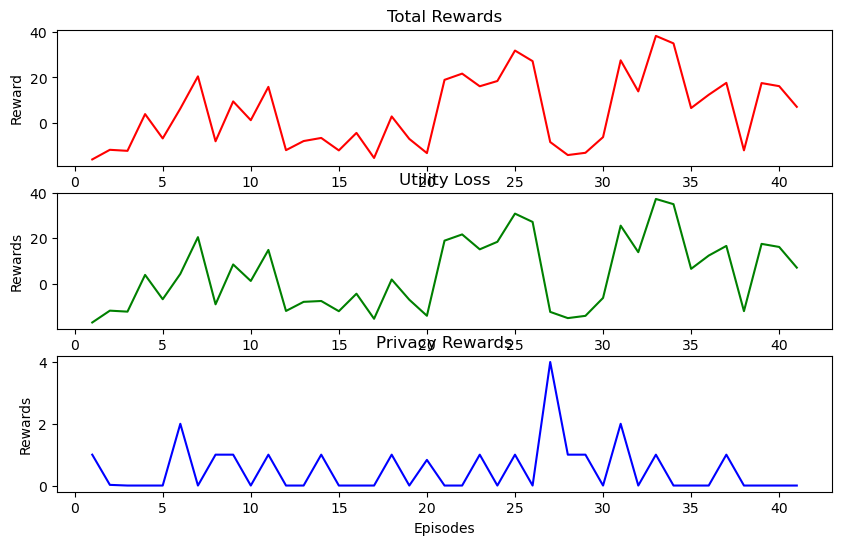

Episode:  41
preward:  tensor(1.)
ureward:  [0.9870126]
preward:  tensor(1.)
ureward:  [1.5600252]
preward:  tensor(1.)
ureward:  [2.097623]
preward:  tensor(0.)
ureward:  [2.1472313]
preward:  tensor(0.)
ureward:  [2.6308804]
preward:  tensor(0.)
ureward:  [3.4843369]
preward:  tensor(0.)
ureward:  [3.9814909]
preward:  tensor(0.)
ureward:  [4.0962553]
preward:  tensor(0.)
ureward:  [5.0962553]
preward:  tensor(0.)
ureward:  [5.616393]
Episode:  42
preward:  tensor(0.)
ureward:  [0.56035733]
preward:  tensor(0.)
ureward:  [0.9380611]
preward:  tensor(0.)
ureward:  [1.6953353]
preward:  tensor(0.)
ureward:  [2.4193606]
preward:  tensor(0.)
ureward:  [2.945551]
preward:  tensor(0.)
ureward:  [3.945551]
preward:  tensor(0.)
ureward:  [4.4237933]
preward:  tensor(0.)
ureward:  [5.0213857]
preward:  tensor(0.)
ureward:  [5.6932225]
preward:  tensor(0.)
ureward:  [6.1675754]
Episode:  43
preward:  tensor(0.)
ureward:  [0.7142711]
preward:  tensor(0.)
ureward:  [0.7639524]
preward:  tensor(0

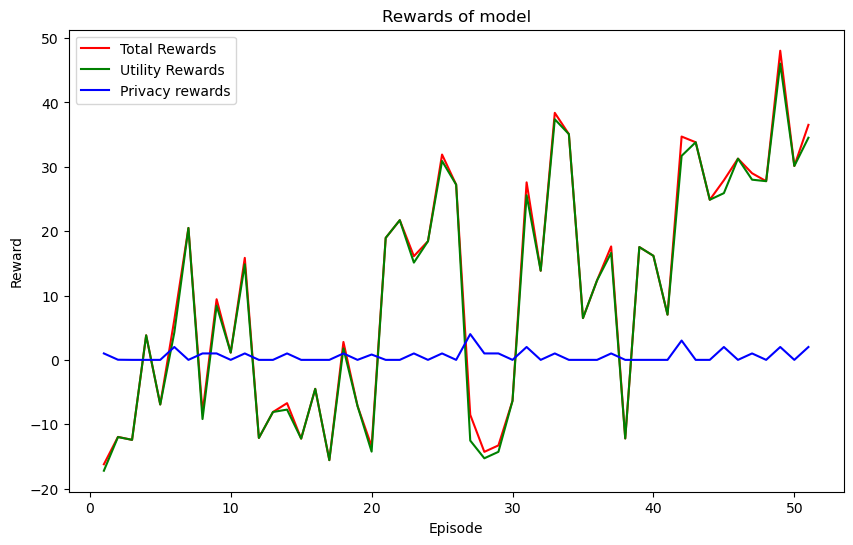

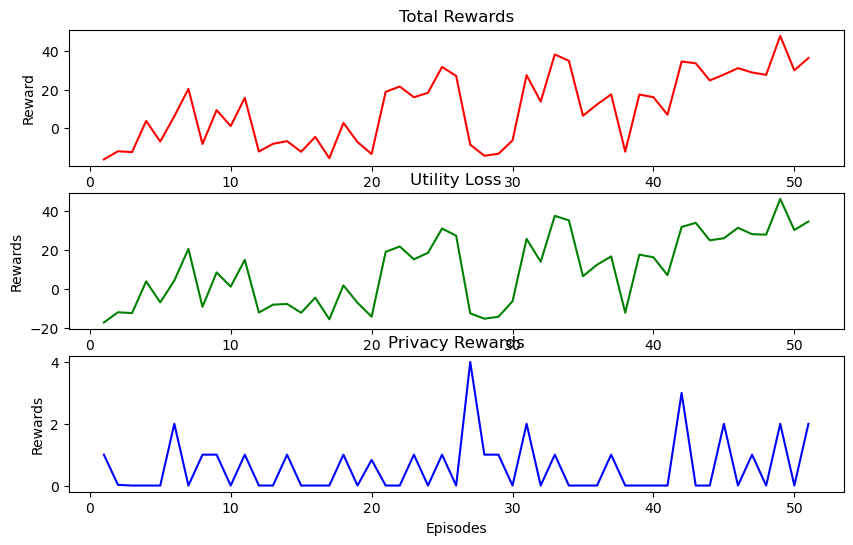

Episode:  51
preward:  tensor(0.)
ureward:  [0.73068506]
preward:  tensor(0.)
ureward:  [1.730685]
preward:  tensor(0.)
ureward:  [2.4544966]
preward:  tensor(0.)
ureward:  [3.1707559]
preward:  tensor(0.)
ureward:  [4.170756]
preward:  tensor(0.)
ureward:  [4.8312]
preward:  tensor(0.)
ureward:  [4.745411]
preward:  tensor(0.)
ureward:  [5.745411]
preward:  tensor(0.)
ureward:  [6.3132553]
preward:  tensor(0.)
ureward:  [7.0266924]
Episode:  52
preward:  tensor(0.)
ureward:  [0.5336335]
preward:  tensor(0.)
ureward:  [0.998368]
preward:  tensor(0.)
ureward:  [1.7599556]
preward:  tensor(0.)
ureward:  [2.7136269]
preward:  tensor(0.)
ureward:  [3.560102]
preward:  tensor(0.)
ureward:  [4.4235544]
preward:  tensor(0.)
ureward:  [5.341107]
preward:  tensor(0.)
ureward:  [6.182995]
preward:  tensor(0.)
ureward:  [7.168391]
preward:  tensor(0.)
ureward:  [8.082703]
Episode:  53
preward:  tensor(0.)
ureward:  [1.]
preward:  tensor(0.)
ureward:  [2.]
preward:  tensor(0.)
ureward:  [2.2386918

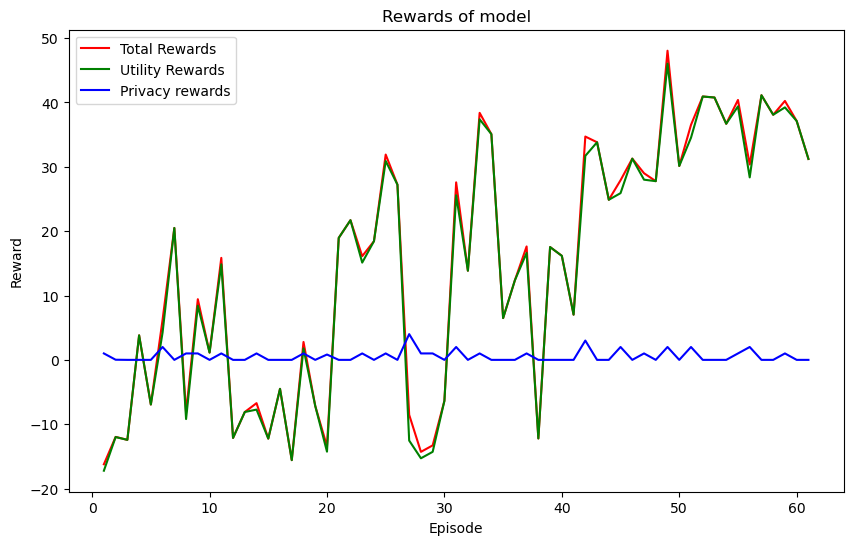

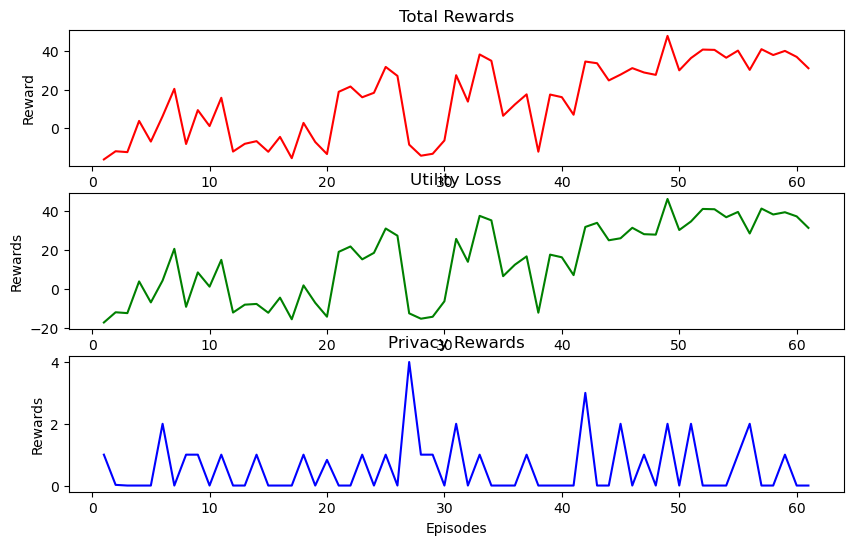

Episode:  61
preward:  tensor(0.)
ureward:  [0.4998693]
preward:  tensor(0.)
ureward:  [1.4998693]
preward:  tensor(0.)
ureward:  [2.4998693]
preward:  tensor(0.)
ureward:  [3.4998693]
preward:  tensor(0.)
ureward:  [4.4998693]
preward:  tensor(0.)
ureward:  [5.4998693]
preward:  tensor(0.)
ureward:  [6.4998693]
preward:  tensor(0.)
ureward:  [6.5856986]
preward:  tensor(0.)
ureward:  [7.5856986]
preward:  tensor(0.)
ureward:  [7.9870787]
Episode:  62
preward:  tensor(1.)
ureward:  [0.75139]
preward:  tensor(6.9645e-05)
ureward:  [1.3144226]
preward:  tensor(0.)
ureward:  [2.0996811]
preward:  tensor(0.)
ureward:  [2.3986332]
preward:  tensor(0.)
ureward:  [2.9682813]
preward:  tensor(0.)
ureward:  [3.3664525]
preward:  tensor(0.)
ureward:  [4.366452]
preward:  tensor(0.)
ureward:  [4.9527054]
preward:  tensor(0.)
ureward:  [5.8507805]
preward:  tensor(0.)
ureward:  [6.114059]
Episode:  63
preward:  tensor(1.)
ureward:  [0.6770048]
preward:  tensor(0.)
ureward:  [1.1820675]
preward:  t

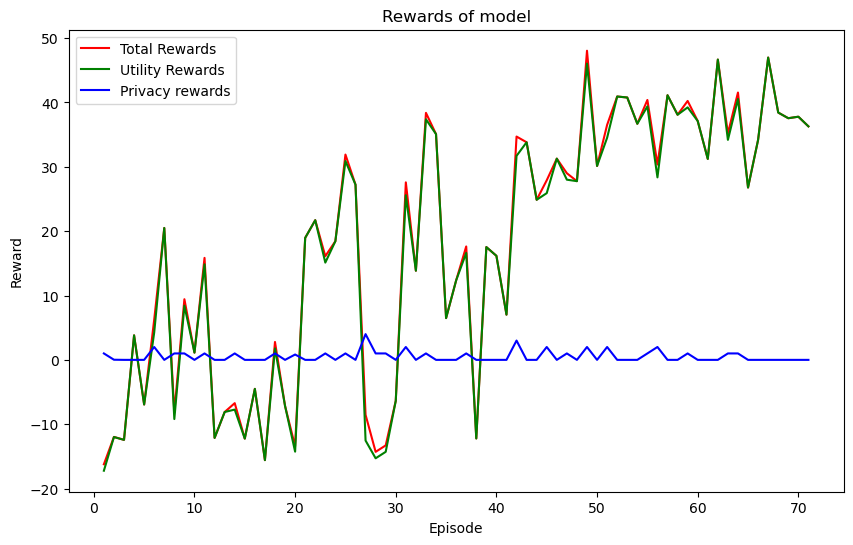

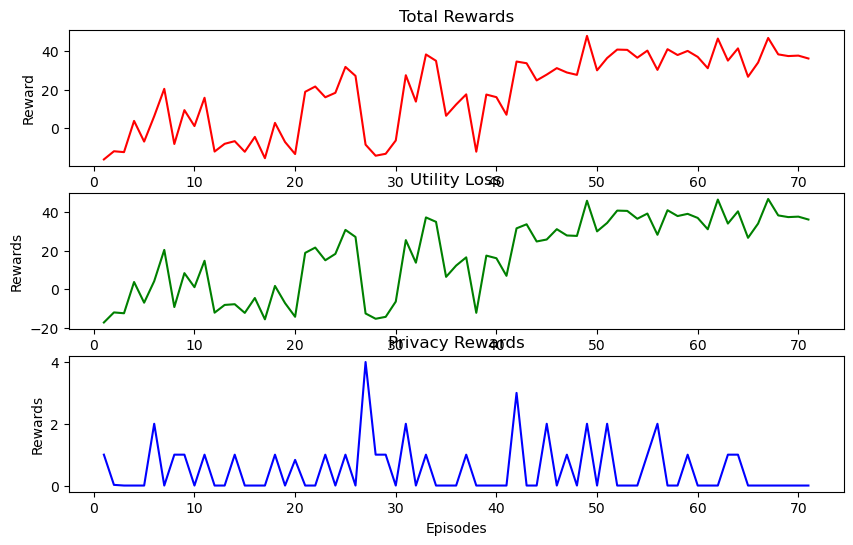

Episode:  71
preward:  tensor(0.)
ureward:  [0.22578976]
preward:  tensor(0.)
ureward:  [0.54998535]
preward:  tensor(0.)
ureward:  [0.54988277]
preward:  tensor(0.)
ureward:  [1.1695575]
preward:  tensor(0.)
ureward:  [0.83389467]
preward:  tensor(0.)
ureward:  [1.8338947]
preward:  tensor(0.)
ureward:  [2.3041062]
preward:  tensor(0.)
ureward:  [3.3041062]
preward:  tensor(0.)
ureward:  [3.3111644]
preward:  tensor(0.)
ureward:  [3.574035]
Episode:  72
preward:  tensor(0.)
ureward:  [-0.56049573]
preward:  tensor(0.)
ureward:  [0.01871163]
preward:  tensor(0.)
ureward:  [0.45007208]
preward:  tensor(0.)
ureward:  [0.32691333]
preward:  tensor(0.)
ureward:  [1.3269134]
preward:  tensor(0.)
ureward:  [2.144395]
preward:  tensor(0.)
ureward:  [3.144395]
preward:  tensor(0.)
ureward:  [4.0374966]
preward:  tensor(0.)
ureward:  [4.967673]
preward:  tensor(0.)
ureward:  [5.967673]
Episode:  73
preward:  tensor(1.)
ureward:  [0.8569397]
preward:  tensor(0.)
ureward:  [1.7791052]
preward:  t

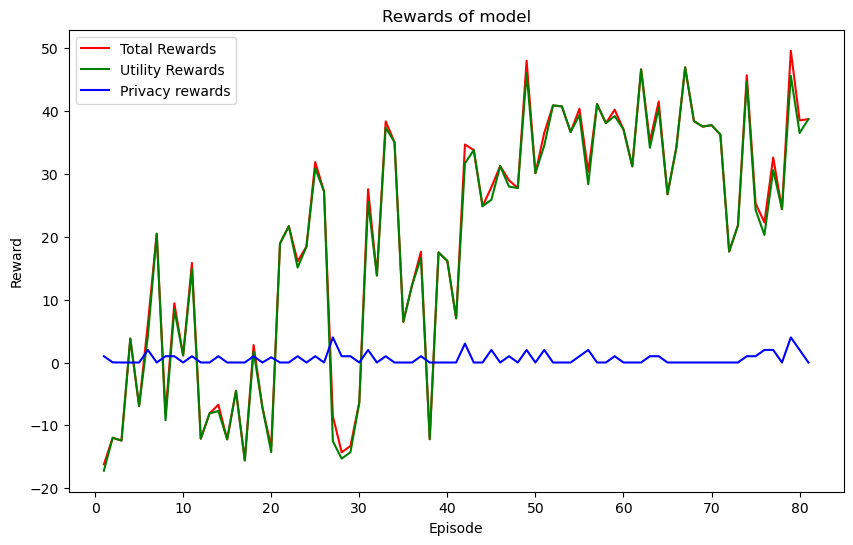

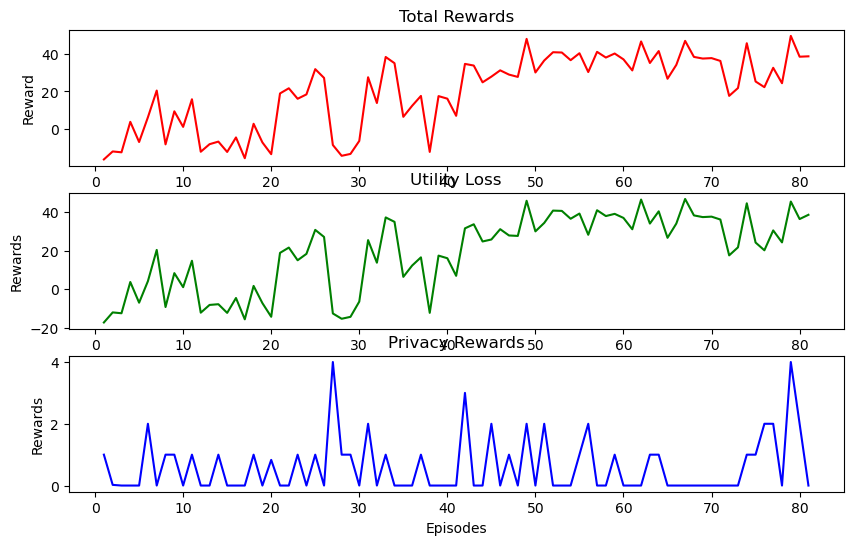

Episode:  81
preward:  tensor(0.)
ureward:  [0.58840173]
preward:  tensor(0.)
ureward:  [1.5884018]
preward:  tensor(0.)
ureward:  [2.2326934]
preward:  tensor(0.)
ureward:  [2.076147]
preward:  tensor(0.)
ureward:  [2.0960047]
preward:  tensor(0.)
ureward:  [1.8917447]
preward:  tensor(0.)
ureward:  [1.7194043]
preward:  tensor(0.)
ureward:  [1.3110855]
preward:  tensor(0.)
ureward:  [1.682632]
preward:  tensor(0.)
ureward:  [2.682632]
Episode:  82
preward:  tensor(0.)
ureward:  [0.27275896]
preward:  tensor(0.)
ureward:  [0.57833815]
preward:  tensor(0.)
ureward:  [1.0602094]
preward:  tensor(0.)
ureward:  [0.9577083]
preward:  tensor(0.)
ureward:  [1.9577084]
preward:  tensor(0.)
ureward:  [2.2175205]
preward:  tensor(0.)
ureward:  [2.4353263]
preward:  tensor(0.)
ureward:  [3.4353263]
preward:  tensor(0.)
ureward:  [3.887464]
preward:  tensor(0.)
ureward:  [4.787689]
Episode:  83
preward:  tensor(0.)
ureward:  [-0.16829342]
preward:  tensor(0.)
ureward:  [0.10766438]
preward:  tens

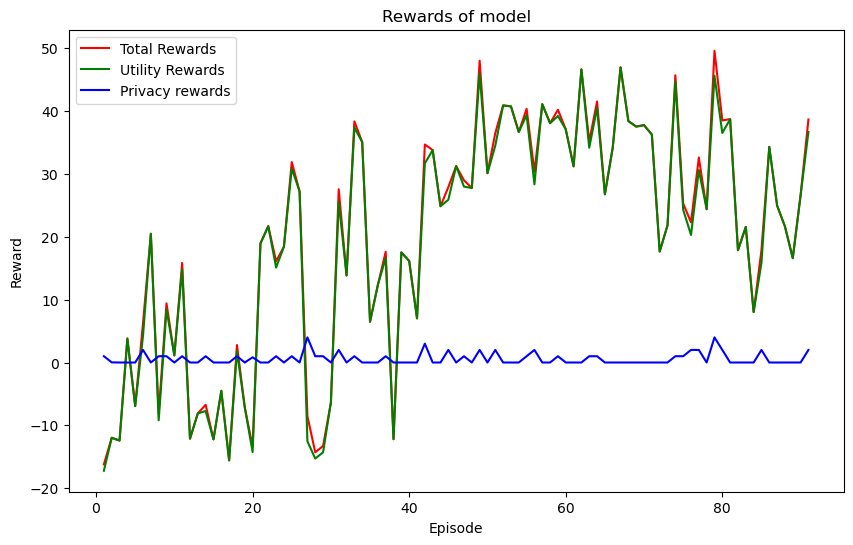

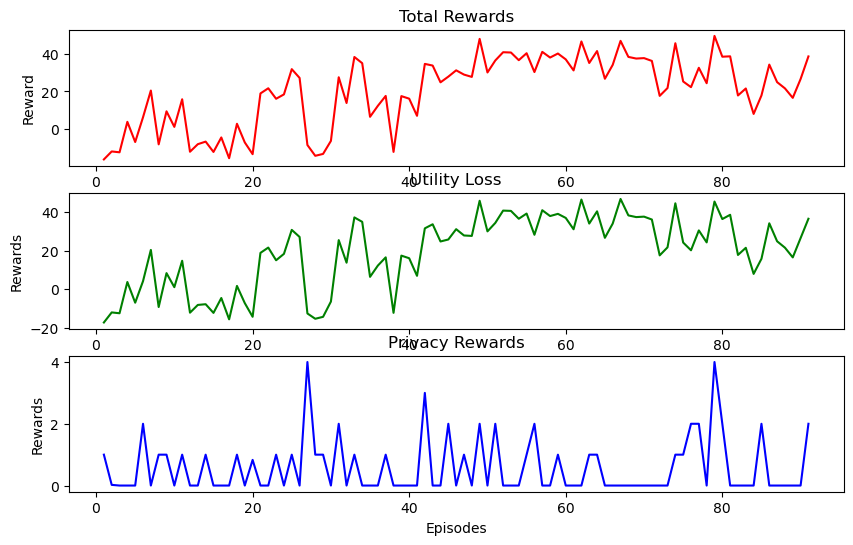

Episode:  91
preward:  tensor(0.)
ureward:  [0.18601662]
preward:  tensor(0.)
ureward:  [0.34817392]
preward:  tensor(0.)
ureward:  [0.3306492]
preward:  tensor(0.)
ureward:  [1.0011785]
preward:  tensor(0.)
ureward:  [1.9403491]
preward:  tensor(0.)
ureward:  [1.366796]
preward:  tensor(0.)
ureward:  [1.9163411]
preward:  tensor(0.)
ureward:  [2.5188491]
preward:  tensor(0.)
ureward:  [3.424886]
preward:  tensor(0.)
ureward:  [4.4248857]
Episode:  92
preward:  tensor(0.)
ureward:  [0.38051587]
preward:  tensor(0.)
ureward:  [0.9937276]
preward:  tensor(0.)
ureward:  [1.7921784]
preward:  tensor(0.)
ureward:  [2.088601]
preward:  tensor(0.)
ureward:  [2.9100676]
preward:  tensor(0.)
ureward:  [3.8364015]
preward:  tensor(0.)
ureward:  [4.237686]
preward:  tensor(0.)
ureward:  [5.237686]
preward:  tensor(0.)
ureward:  [5.357142]
preward:  tensor(0.)
ureward:  [6.357142]
Episode:  93
preward:  tensor(1.)
ureward:  [0.06667036]
preward:  tensor(0.)
ureward:  [0.86529535]
preward:  tensor(

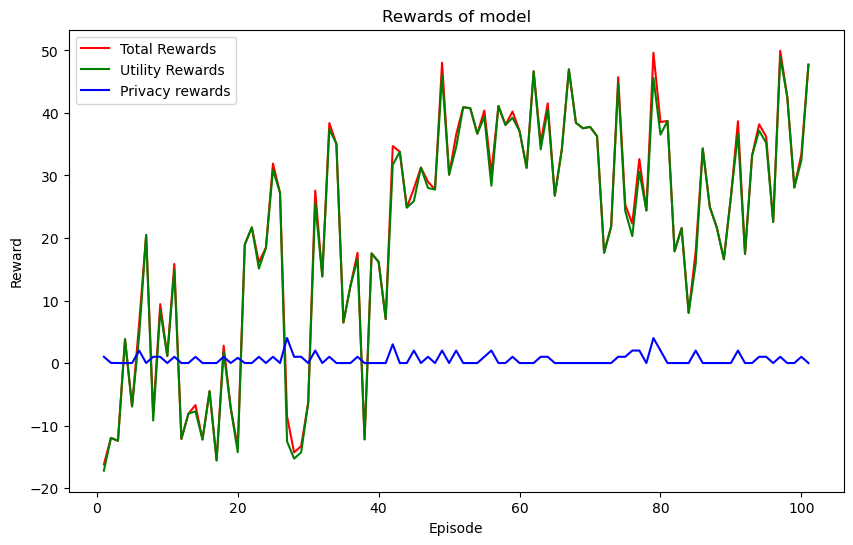

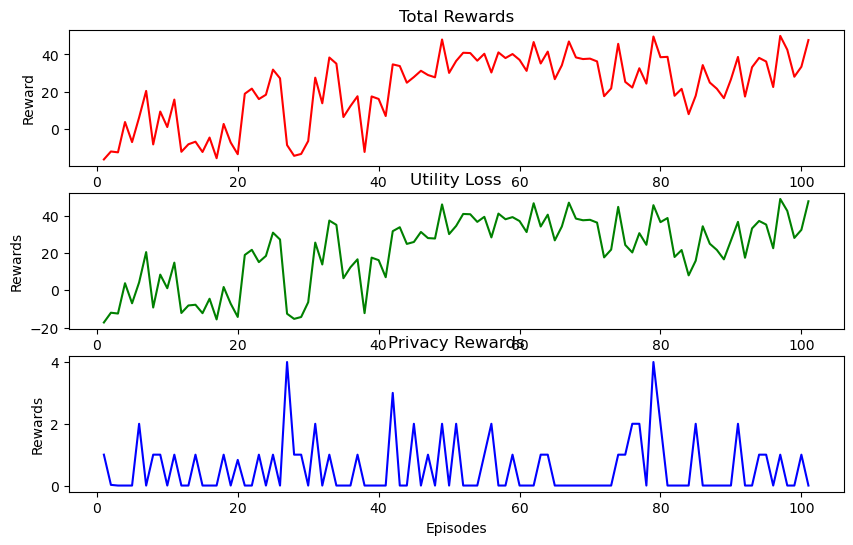

Episode:  101
preward:  tensor(0.0003)
ureward:  [0.23923653]
preward:  tensor(0.)
ureward:  [1.1089904]
preward:  tensor(0.)
ureward:  [1.8790267]
preward:  tensor(0.)
ureward:  [2.8790267]
preward:  tensor(0.)
ureward:  [3.8790267]
preward:  tensor(0.)
ureward:  [4.859461]
preward:  tensor(0.)
ureward:  [5.580309]
preward:  tensor(0.)
ureward:  [6.580309]
preward:  tensor(0.)
ureward:  [6.7451677]
preward:  tensor(0.)
ureward:  [7.482731]
Episode:  102
preward:  tensor(1.)
ureward:  [1.]
preward:  tensor(1.)
ureward:  [1.4500934]
preward:  tensor(1.2022e-05)
ureward:  [2.4500933]
preward:  tensor(0.)
ureward:  [3.4500933]
preward:  tensor(0.)
ureward:  [3.1963525]
preward:  tensor(0.)
ureward:  [3.9509096]
preward:  tensor(0.)
ureward:  [4.8429127]
preward:  tensor(0.)
ureward:  [5.8429127]
preward:  tensor(0.)
ureward:  [6.8429127]
preward:  tensor(0.)
ureward:  [7.8429127]
Episode:  103
preward:  tensor(0.)
ureward:  [1.]
preward:  tensor(0.)
ureward:  [1.4781759]
preward:  tensor(

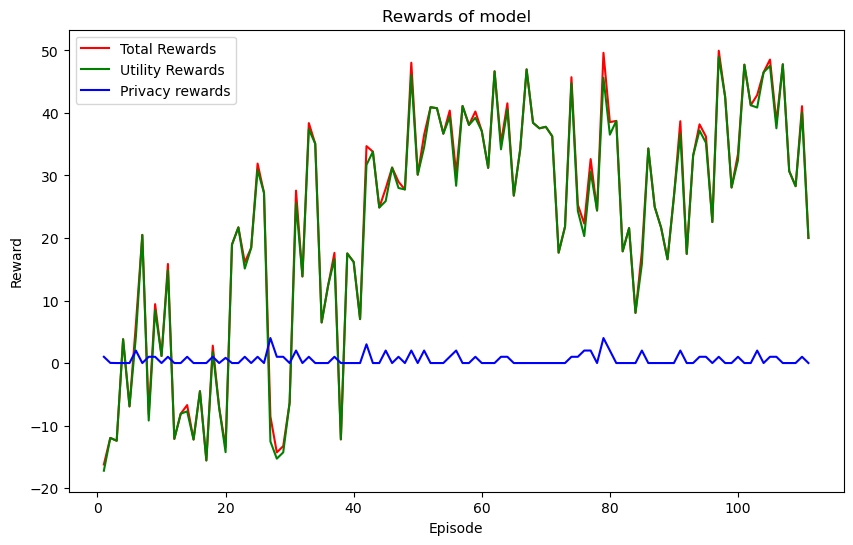

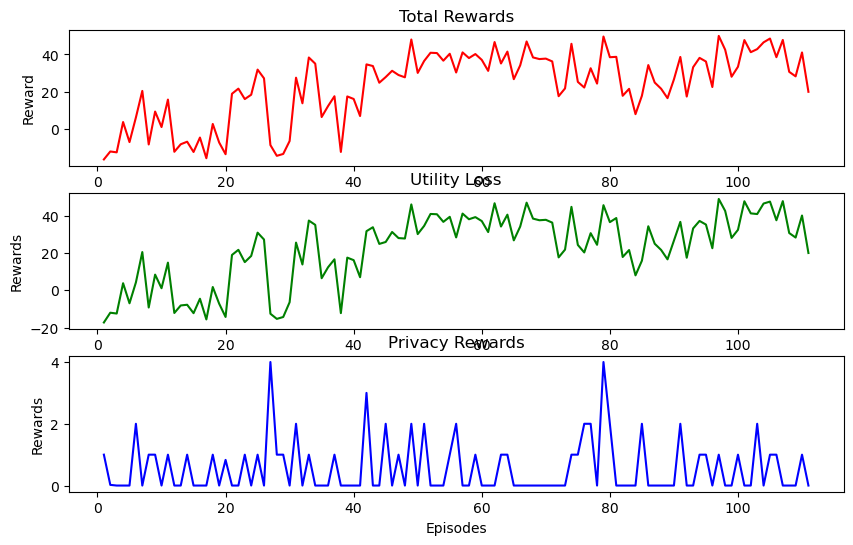

Episode:  111
preward:  tensor(2.9272e-06)
ureward:  [0.906402]
preward:  tensor(0.)
ureward:  [1.5472736]
preward:  tensor(0.)
ureward:  [1.8779746]
preward:  tensor(0.)
ureward:  [2.1179292]
preward:  tensor(0.)
ureward:  [1.8514366]
preward:  tensor(0.)
ureward:  [2.8514366]
preward:  tensor(0.)
ureward:  [3.607666]
preward:  tensor(0.)
ureward:  [3.8535044]
preward:  tensor(0.)
ureward:  [4.853504]
preward:  tensor(0.)
ureward:  [5.3020463]
Episode:  112
preward:  tensor(1.)
ureward:  [0.06028765]
preward:  tensor(0.)
ureward:  [0.31441912]
preward:  tensor(0.)
ureward:  [1.02292]
preward:  tensor(0.)
ureward:  [2.0229201]
preward:  tensor(0.)
ureward:  [2.2955213]
preward:  tensor(0.)
ureward:  [2.4389877]
preward:  tensor(0.)
ureward:  [2.580365]
preward:  tensor(0.)
ureward:  [3.580365]
preward:  tensor(0.)
ureward:  [4.580365]
preward:  tensor(0.)
ureward:  [4.571823]
Episode:  113
preward:  tensor(0.)
ureward:  [0.98790115]
preward:  tensor(0.)
ureward:  [1.4964159]
preward:  

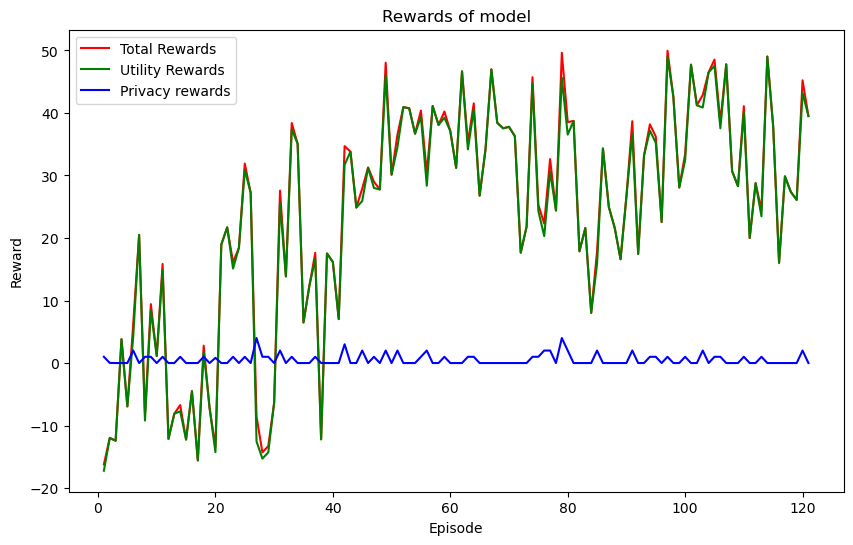

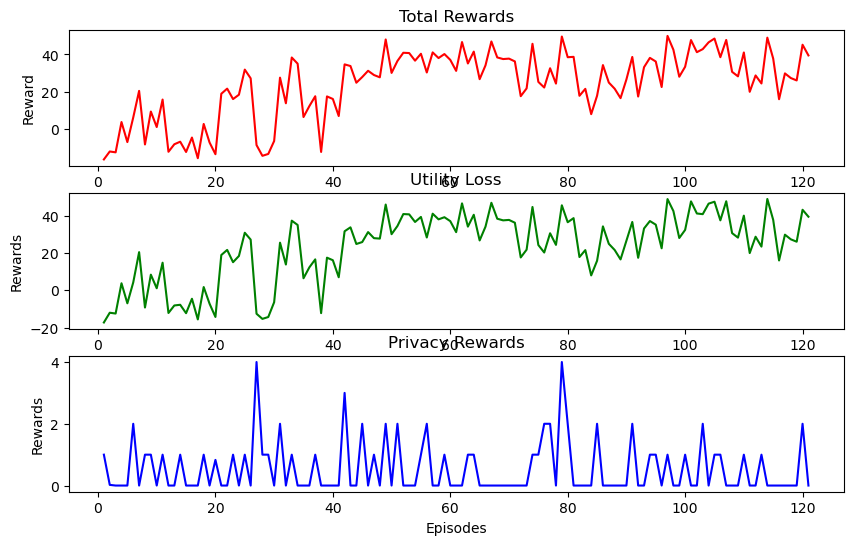

Episode:  121
preward:  tensor(0.)
ureward:  [0.86564463]
preward:  tensor(0.)
ureward:  [1.8656447]
preward:  tensor(0.)
ureward:  [2.6384811]
preward:  tensor(0.)
ureward:  [2.9969144]
preward:  tensor(0.)
ureward:  [3.6151094]
preward:  tensor(0.)
ureward:  [4.411907]
preward:  tensor(0.)
ureward:  [5.411907]
preward:  tensor(0.)
ureward:  [5.4404297]
preward:  tensor(0.)
ureward:  [6.4404297]
preward:  tensor(0.)
ureward:  [7.0474524]
Episode:  122
preward:  tensor(1.)
ureward:  [1.]
preward:  tensor(1.)
ureward:  [1.6422011]
preward:  tensor(0.)
ureward:  [2.3352885]
preward:  tensor(0.)
ureward:  [2.453932]
preward:  tensor(0.)
ureward:  [3.3793674]
preward:  tensor(0.)
ureward:  [3.971093]
preward:  tensor(0.)
ureward:  [4.971093]
preward:  tensor(0.)
ureward:  [5.871506]
preward:  tensor(0.)
ureward:  [6.3511553]
preward:  tensor(0.)
ureward:  [6.484894]
Episode:  123
preward:  tensor(0.)
ureward:  [0.94084316]
preward:  tensor(0.)
ureward:  [1.9408431]
preward:  tensor(0.)
ure

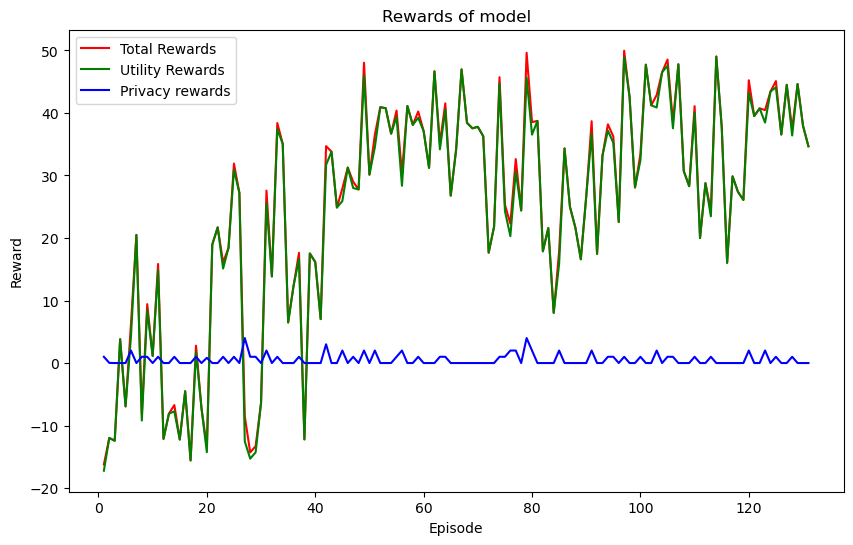

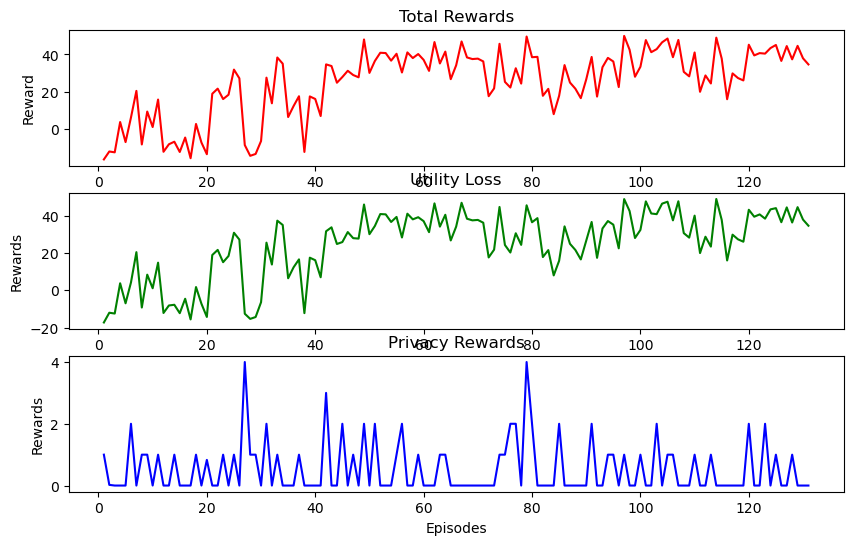

Episode:  131
preward:  tensor(1.)
ureward:  [1.]
preward:  tensor(1.)
ureward:  [1.7653852]
preward:  tensor(0.)
ureward:  [2.715848]
preward:  tensor(0.)
ureward:  [3.4133577]
preward:  tensor(0.)
ureward:  [4.4133577]
preward:  tensor(0.)
ureward:  [5.4133577]
preward:  tensor(0.)
ureward:  [6.4133577]
preward:  tensor(0.)
ureward:  [7.3525424]
preward:  tensor(0.)
ureward:  [7.6002817]
preward:  tensor(0.)
ureward:  [8.078624]
Episode:  132
preward:  tensor(0.)
ureward:  [1.]
preward:  tensor(0.)
ureward:  [2.]
preward:  tensor(0.)
ureward:  [3.]
preward:  tensor(0.)
ureward:  [3.7031722]
preward:  tensor(0.)
ureward:  [4.2329607]
preward:  tensor(0.)
ureward:  [5.2287064]
preward:  tensor(0.)
ureward:  [5.858781]
preward:  tensor(0.)
ureward:  [6.858781]
preward:  tensor(0.)
ureward:  [7.858781]
preward:  tensor(0.)
ureward:  [8.858781]
Episode:  133
preward:  tensor(0.)
ureward:  [1.]
preward:  tensor(0.)
ureward:  [1.3979942]
preward:  tensor(0.)
ureward:  [2.0246537]
preward:  

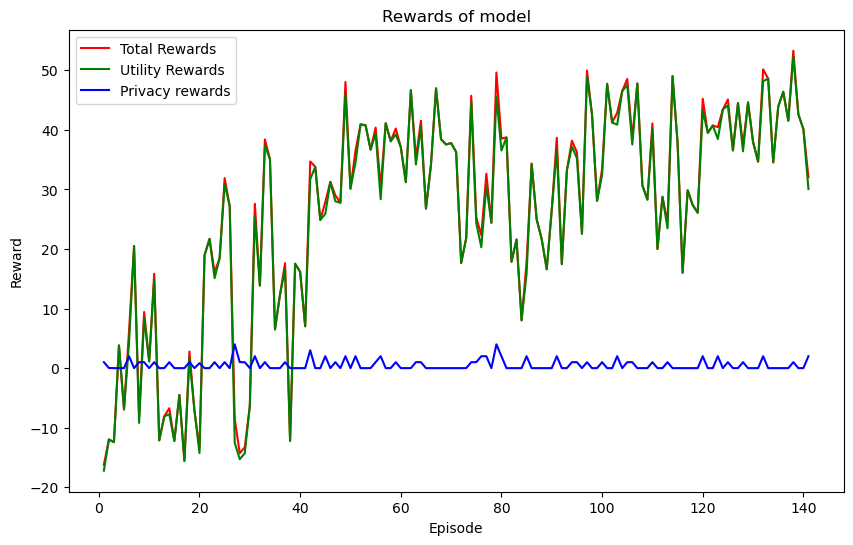

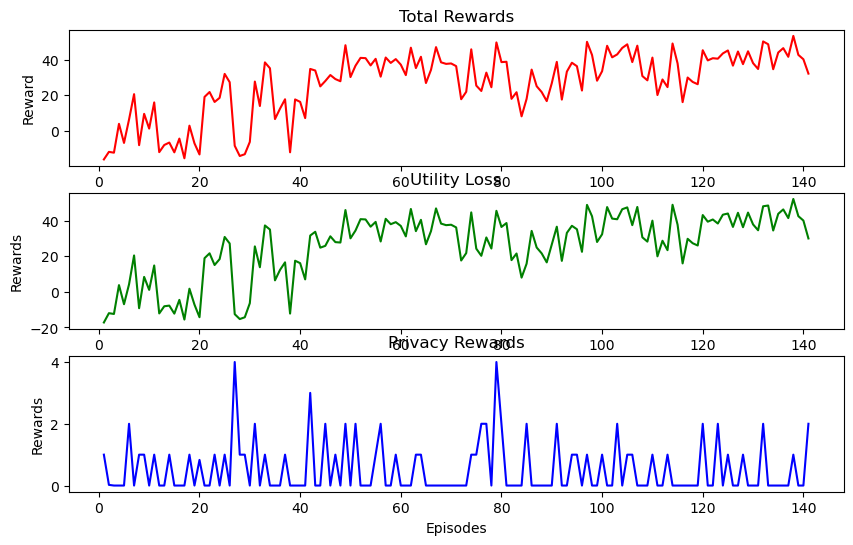

Episode:  141
preward:  tensor(0.)
ureward:  [1.]
preward:  tensor(0.)
ureward:  [1.7052153]
preward:  tensor(0.)
ureward:  [2.4216309]
preward:  tensor(0.)
ureward:  [2.9955878]
preward:  tensor(0.)
ureward:  [3.9955878]
preward:  tensor(0.)
ureward:  [4.995588]
preward:  tensor(0.)
ureward:  [5.9652743]
preward:  tensor(0.)
ureward:  [6.9652743]
preward:  tensor(0.)
ureward:  [7.824193]
preward:  tensor(0.)
ureward:  [8.824193]
Episode:  142
preward:  tensor(1.)
ureward:  [0.70993435]
preward:  tensor(0.)
ureward:  [1.7099344]
preward:  tensor(0.)
ureward:  [2.3516734]
preward:  tensor(0.)
ureward:  [3.3258703]
preward:  tensor(0.)
ureward:  [4.2001534]
preward:  tensor(0.)
ureward:  [5.2001534]
preward:  tensor(0.)
ureward:  [5.8606286]
preward:  tensor(0.)
ureward:  [6.8606286]
preward:  tensor(0.)
ureward:  [7.695773]
preward:  tensor(0.)
ureward:  [8.695773]
Episode:  143
preward:  tensor(1.)
ureward:  [0.9825678]
preward:  tensor(4.2359e-05)
ureward:  [1.4886245]
preward:  tenso

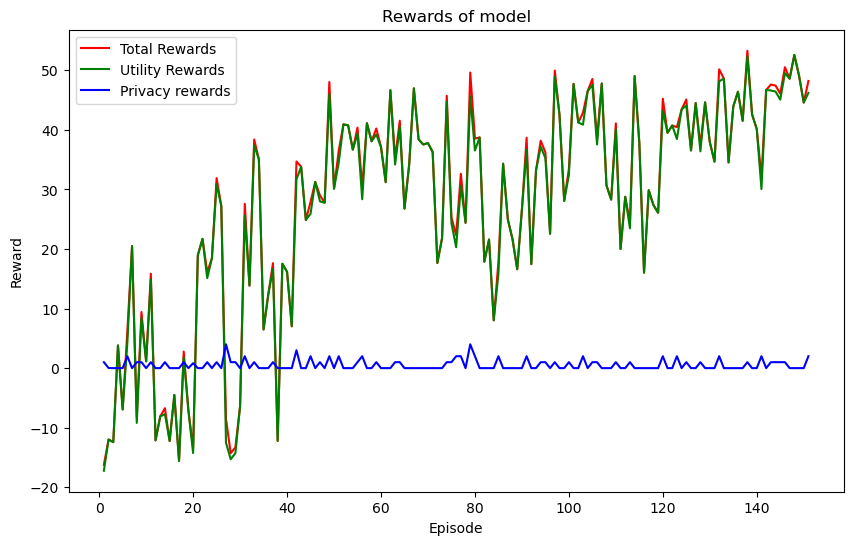

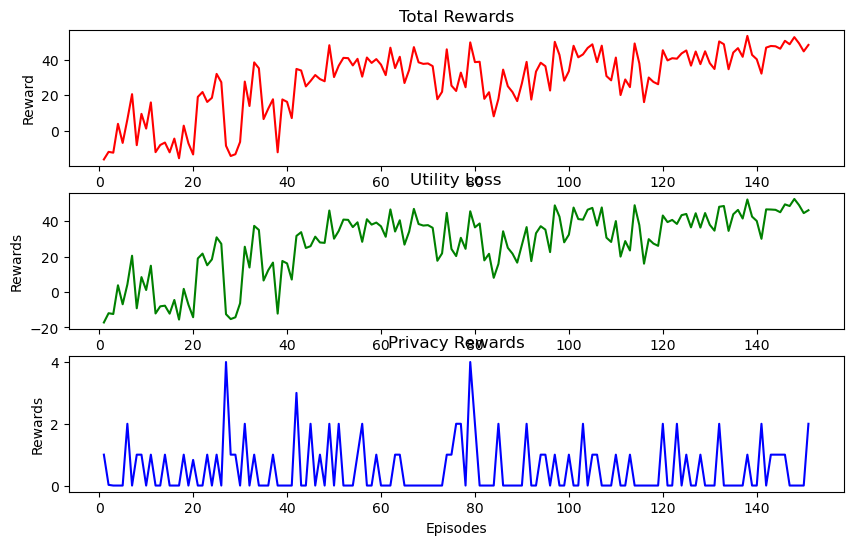

Episode:  151
preward:  tensor(1.)
ureward:  [0.52310026]
preward:  tensor(0.)
ureward:  [1.5231003]
preward:  tensor(0.)
ureward:  [2.0095732]
preward:  tensor(0.)
ureward:  [3.0095732]
preward:  tensor(0.)
ureward:  [4.009573]
preward:  tensor(0.)
ureward:  [5.009573]
preward:  tensor(0.)
ureward:  [6.009573]
preward:  tensor(0.)
ureward:  [6.8659625]
preward:  tensor(0.)
ureward:  [7.096781]
preward:  tensor(0.)
ureward:  [8.096781]
Episode:  152
preward:  tensor(1.)
ureward:  [0.85930884]
preward:  tensor(0.)
ureward:  [1.8593088]
preward:  tensor(0.)
ureward:  [2.5518413]
preward:  tensor(0.)
ureward:  [3.076607]
preward:  tensor(0.)
ureward:  [4.0766068]
preward:  tensor(0.)
ureward:  [5.0766068]
preward:  tensor(0.)
ureward:  [6.0766068]
preward:  tensor(0.)
ureward:  [7.0766068]
preward:  tensor(0.)
ureward:  [8.076607]
preward:  tensor(0.)
ureward:  [9.03478]
Episode:  153
preward:  tensor(1.)
ureward:  [0.9444585]
preward:  tensor(0.)
ureward:  [1.9444585]
preward:  tensor(0.

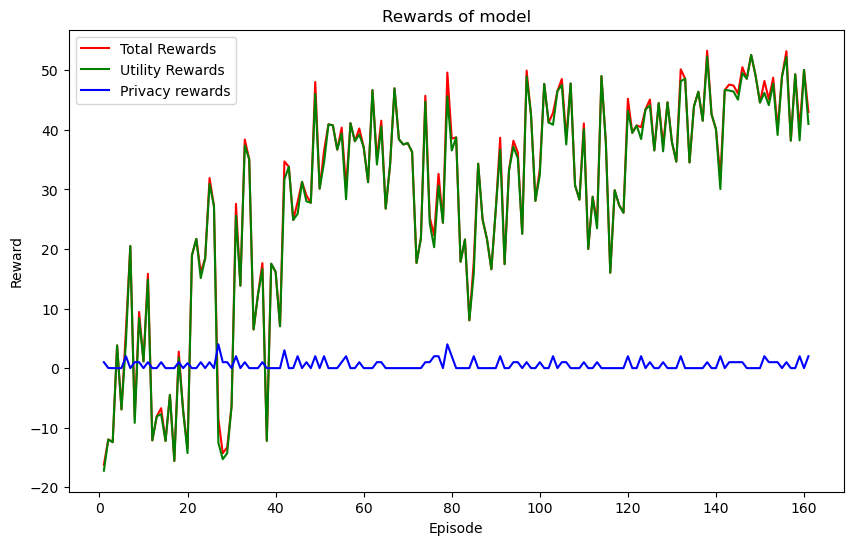

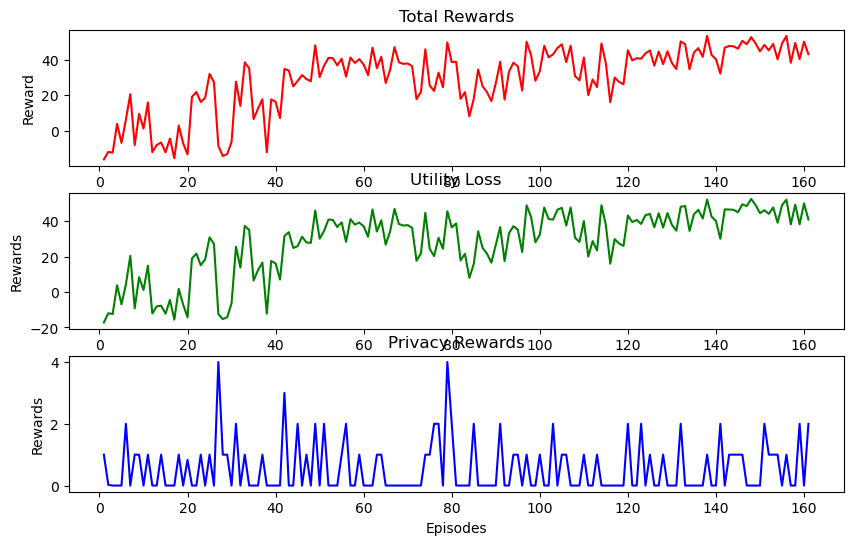

Episode:  161
preward:  tensor(1.)
ureward:  [0.90868115]
preward:  tensor(0.)
ureward:  [1.9086812]
preward:  tensor(0.)
ureward:  [2.7332761]
preward:  tensor(0.)
ureward:  [3.7332761]
preward:  tensor(0.)
ureward:  [4.012255]
preward:  tensor(0.)
ureward:  [4.9524064]
preward:  tensor(0.)
ureward:  [5.9524064]
preward:  tensor(0.)
ureward:  [6.9524064]
preward:  tensor(0.)
ureward:  [7.9524064]
preward:  tensor(0.)
ureward:  [8.952406]
Episode:  162
preward:  tensor(0.)
ureward:  [0.9701398]
preward:  tensor(0.)
ureward:  [1.9423456]
preward:  tensor(0.)
ureward:  [2.9423456]
preward:  tensor(0.)
ureward:  [3.9423456]
preward:  tensor(0.)
ureward:  [4.7132406]
preward:  tensor(0.)
ureward:  [5.7132406]
preward:  tensor(0.)
ureward:  [6.7132406]
preward:  tensor(0.)
ureward:  [7.7132406]
preward:  tensor(0.)
ureward:  [8.5783615]
preward:  tensor(0.)
ureward:  [9.24499]
Episode:  163
preward:  tensor(0.)
ureward:  [0.8917985]
preward:  tensor(0.)
ureward:  [1.8917985]
preward:  tenso

KeyboardInterrupt: 

In [14]:
%load_ext autoreload
%autoreload 2
from environment import BeaconEnv
from ppo import PPO
from utils import plot_rewards, plot_individual_rewards

print("============================================================================================")

################# training procedure ################
env = BeaconEnv(args, beacon, maf_values, binary)
state_dim = args.beacon_size * args.gene_size * 4
action_dim = env.action_space.shape[0]

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


################### Logging ###################
run_num = 0
current_num_files = next(os.walk(args.results_dir))[2]
run_num = len(current_num_files)
log_f_name = args.results_dir + '/PPO_' + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + " : ", run_num)
print("logging at : " + log_f_name)

################### checkpointing ###################
directory = args.results_dir + "/weights"
if not os.path.exists(directory):
      os.makedirs(directory)

checkpoint_path = directory + "/PPO_{}.pth".format(run_num)
print("save checkpoint path : " + checkpoint_path)

log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


privacy_rewards = []
utility_rewards = []
total_rewards = []


# training loop
while i_episode <= args.episodes:

    state = env.reset()[1]
    # print(state.size())
    current_ep_reward = 0

    current_ep_preward = 0
    current_ep_ureward = 0

    print("Episode: ", i_episode)


    for t in range(1, args.max_queries+1):

        # select action with policy
        state = torch.flatten(state)
        action = ppo_agent.select_action(state)
        state, reward, done, rewards = env.step(action)

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward
        current_ep_preward += rewards[0]
        current_ep_ureward += rewards[1]
        if done:
            break

    # update PPO agent
    if i_episode % (args.pop_reset_freq/2) == 0 and i_episode>0:
        print("updating the agent")
        ppo_agent.update()

        # log average reward till last episode
        log_avg_reward = log_running_reward / log_running_episodes
        log_avg_reward = log_avg_reward

        log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
        log_f.flush()

        log_running_reward = 0
        log_running_episodes = 0

        # print average reward till last episode
        print_avg_reward = print_running_reward / print_running_episodes
        print_avg_reward = print_avg_reward

        print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

        print_running_reward = 0
        print_running_episodes = 0

        # save model weights
        print("--------------------------------------------------------------------------------------------")
        print("saving model at : " + checkpoint_path)
        ppo_agent.save(checkpoint_path)
        print("model saved")
        print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
        print("--------------------------------------------------------------------------------------------")


    # if continuous action space; then decay action std of ouput action distribution
    if has_continuous_action_space and i_episode % (args.episodes/4)==0 and i_episode>0 == 0:
        ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)


    total_rewards.append(current_ep_reward)
    utility_rewards.append(current_ep_ureward)
    privacy_rewards.append(current_ep_preward)

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    if i_episode % 10 == 0 and i_episode > 0:
        plot_rewards(total_rewards, utility_rewards, privacy_rewards)
        plot_individual_rewards(total_rewards, utility_rewards, privacy_rewards)

    i_episode += 1



log_f.close()
env.close()


# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")